<a href="https://colab.research.google.com/github/halmichchristina/Colab/blob/master/W_GPU_WGAIN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAIN GPU

## Needed Packages

In [0]:
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import torch.tensor as tensor
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.optim as optim
#Gradient Penalty
import torch.autograd as autograd

#GPU
!pip install --upgrade pycuda
import pycuda.driver as cuda 
import pycuda.autoinit # Necessary for using its functions
#Time
import time

Requirement already up-to-date: pycuda in /usr/local/lib/python3.6/dist-packages (2019.1.2)


## GPU Test

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# A simple class to know about your cuda devices
cuda.init() # Necesarry for using its functions

class aboutCudaDevices():
    def __init__(self):
        pass
    
    def num_devices(self):
        """Return number of devices connected."""
        return cuda.Device.count()
    
    def devices(self):
        """Get info on all devices connected."""
        num = cuda.Device.count()
        print("%d device(s) found:"%num)
        for i in range(num):
            print(cuda.Device(i).name(), "(Id: %d)"%i)
            
    def mem_info(self):
        """Get available and total memory of all devices."""
        available, total = cuda.mem_get_info()
        print("Available: %.2f GB\nTotal:     %.2f GB"%(available/1e9, total/1e9))
        
    def attributes(self, device_id=0):
        """Get attributes of device with device Id = device_id"""
        return cuda.Device(device_id).get_attributes()
    
    def __repr__(self):
        """Class representation as number of devices connected and about them."""
        num = cuda.Device.count()
        string = ""
        string += ("%d device(s) found:\n"%num)
        for i in range(num):
            string += ( "    %d) %s (Id: %d)\n"%((i+1),cuda.Device(i).name(),i))
            string += ("          Memory: %.2f GB\n"%(cuda.Device(i).total_memory()/1e9))
        return string

# You can print output just by typing its name (__repr__):
print(aboutCudaDevices())
# 1 device(s) found:
#    1) Tesla K80 (Id: 0)
#          Memory: 12.00 GB

# Returns the current GPU memory usage by 
# tensors in bytes for a given device
print(torch.cuda.memory_allocated())

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
print(torch.cuda.memory_cached())

cuda:0
1 device(s) found:
    1) Tesla K80 (Id: 0)
          Memory: 12.00 GB

0
0


In [0]:
#next(D.parameters()).is_cuda # Ceck if mod is on GPU

## Generator and Discriminator

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x_in, m, z): #hier als x bereits bearbeitete
        inp =(1-m)*z# noise for missing values 
        input_x = torch.cat((x_in,m,inp),dim = 1)
        x = F.relu(self.map1(input_x.cuda()))
        x = F.relu(self.map2(x))
        x = torch.tanh(self.map3(x))
        return x
      

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x_h, h):
        input_x = torch.cat((x_h,h),dim = 1)
        x = F.relu(self.map1(input_x.cuda()))
        x = F.relu(self.map2(x))
        x = torch.sigmoid(self.map3(x))
        #output in WGAN = 1
        # x =  torch.sigmoid(self.map3(x))
        return x 

## Sampling of M, Z , H

In [0]:
# Mask Vector
def sample_M(samples, n, p):
    A = torch.from_numpy(np.random.uniform(0., 1., size = [samples, n])).double()
    B = A > p
    C = 1.*B  
    return C.to(device)

# Random sample generator for Z
def sample_Z(samples, n):
    return torch.from_numpy(np.random.uniform(0., 1., size = [samples, n])).double()


In [0]:
# Hint for fake values -> Set 0.5 for one 0
def get_fake_H(M):
    H_fake = M.clone()
    samples, n = H_fake.shape
    m_index = torch.arange(samples, dtype=torch.long)
    n_index = m_index.clone()    
    for mi in m_index:  
        pos = (M[mi] == 0).nonzero()
        n_i= torch.from_numpy(np.asanyarray(np.random.choice(pos[:,0])))
        H_fake[mi, n_i] = 0.5       
    indices = zip(m_index, n_index)
    return H_fake.to(device), indices

  
  
# Hint for real values -> Set 0.5 for one 1
def get_real_H(M):
    H_fake = M.clone()
    samples, n = H_fake.shape
    m_index = torch.arange(samples, dtype=torch.long)
    n_index = m_index.clone()    
    for mi in m_index:  
        pos = (M[mi] == 1).nonzero()
        n_i= torch.from_numpy(np.asanyarray(np.random.choice(pos[:,0])))
        H_fake[mi, n_i] = 0.5       
    indices = zip(m_index, n_index)
    return H_fake.to(device), indices

## Get data

In [0]:
def prepare_data(p, dim, input_dim, batch, print_ex):
    # X, M , Z
    root = './data'
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch, shuffle=True)
    
    
    # get some random training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.to(device)
    x = images.view(-1,input_dim)
     
    m = sample_M(batch, input_dim, p)
    z = sample_Z(batch, input_dim)
    #show example
    if print_ex == 1: 
        
        exX = x.view(-1,1,dim,dim)
        exM = m.view(-1,1,dim,dim).cpu().double()
        imshow(torchvision.utils.make_grid(exX[0]))
        imshow(torchvision.utils.make_grid(exM[0]))
        #im =exX[0]*exM[0]
        #imshow(torchvision.utils.make_grid(im))
        print(x.shape)
        print(z.shape)
        print(m.shape)
        
    return x.float().to(device),m.float().to(device),z.float().to(device)

## Loss, Show, GP Function

In [0]:
def imshow(img, title):
    fig, ax = plt.subplots(figsize=(15,5))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
   

In [0]:
def calc_gradient_penalty(D, x_real, x_s,h):
    #Where x_s is the output of the Generator
    a = torch.rand(batch, 1)
    a = a.expand(x_real.size())
    a = a.to(device)
    #print("# DEBUG:::a.shape = " + str(a.shape))
    #print("# DEBUG:::x_real.shape = " + str(x_real.shape))
    #print("# DEBUG:::x_s.shape = " + str(x_s.shape))
    interpolates = a * x_real + ((1 - a) * x_s)
    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    out = D(interpolates,h)
  
    gradients = autograd.grad(outputs=out, inputs=interpolates,
                              grad_outputs=torch.ones(out.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty
    
    

In [0]:
def calc_MSE(calc_x,real_x,m):
  samples, n = m.shape
  m_index = torch.arange(samples, dtype=torch.long)
  res= 0
  for mi in m_index:  
    print('mi', mi)
    pos = (m[mi] == 1).nonzero()
    #print('pos', pos)
    res += torch.sum(calc_x[pos] - real_x[pos])**2
  return res.to(device)

## RUN

### Settings

In [0]:
# Varaibles Run
num_epochs =5000
p_miss = 0.2
batch = 150
dim = 28

#Parameters
d_learning_rate = 1e-6  
g_learning_rate = 1e-4  
g_sgd_momentum = 0.2
d_sgd_momentum = 0.9
e = 1E-8
alpha = 10
LAMBDA = 10 #Gradient Penalty

#Variables Net
input_dim = 784
g_hidden_size = 392
g_output_size = 784
d_hidden_size = 392
d_output_size = 1



#Nets
G = Generator(input_size=input_dim*3, hidden_size= g_hidden_size,output_size=g_output_size)
D = Discriminator(input_size=input_dim*2, hidden_size=d_hidden_size, output_size=d_output_size)
G = G.to(device)
D = D.to(device)

#Loss for real observed and computed observed
L_M = nn.MSELoss().cuda()

#Optimize

#adam geht auch gut
d_optimizer = optim.RMSprop(D.parameters(), lr=d_learning_rate)# , weight_decay =d_sgd_momentum)
g_optimizer = optim.RMSprop(G.parameters(), lr=g_learning_rate)# ,momentum=g_sgd_momentum)

#Error List
plot_rmse,plot_G,plot_D = [],[],[]


### Get Image for Comparison

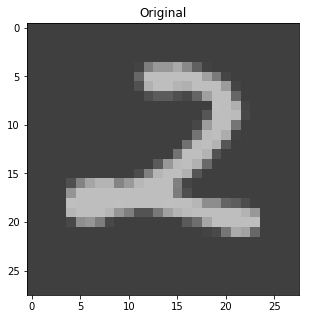

In [0]:
x,m,z = prepare_data(p_miss, dim, input_dim, batch,0)
moh = x
moh_x = x.view(-1,1,dim,dim)
bla = moh_x[0]
imshow(torchvision.utils.make_grid(bla), 'Original')

### GAIN

In [0]:
start_complete = time.time()
for epoch in range(num_epochs): #or while train_loss not converged do:  
    #1.Train D with fixed G
    D.zero_grad()
    G.zero_grad()
    
    #Get Data
    x,m,z = prepare_data( p_miss, dim, input_dim, batch,0)
    x_in = m*x

    #Run Generator
    x_s = G(x_in.to(device), m, z)
    x_h = m*x_in+(1-m)*x_s
    
    #Get H for fake and real
    h_real, indices_real = get_real_H(m.cpu())
    h_fake, indices_fake = get_fake_H(m.cpu())
    
    #Train Only Discriminator
    m_h_real = D(x_h.to(device),h_real.to(device))
    m_h_fake = D(x_h.to(device),h_fake.to(device))
      
    
    #Calculate Gradient Penalty
    gradient_penalty = calc_gradient_penalty(D, x, x_s,h_fake) #h_real oder h_fake?
    
    D.zero_grad()
    
    
    # E_real so groß wie möglich E_fake so klein wie möglich
    D_loss = torch.mean(m_h_fake)-torch.mean(m_h_real) + gradient_penalty

    
    D_loss.backward() 
    d_optimizer.step()     
        
    

                        #Gentrennt optimiern
                        #m_h_real.backward()
                        #m_h_real.step()
                        #m_h_fake.backward()
                        #m_h_fake.step()


  #2.Train G on D's response (but DO NOT train D on these labels)
    G.zero_grad()
    D.zero_grad()
    
    #Get Data
    x,m,z = prepare_data( p_miss, dim, input_dim, batch,0)
    x_in = m*x
    
    #Run Generator
    x_s = G(x_in.to(device), m, z)
    x_h = m*x_in+(1-m)*x_s
    
    
    #Get H for fake and real
    h_real, indices_real = get_real_H(m.cpu())
    h_fake, indices_fake = get_fake_H(m.cpu())
    
    #Train Only Discriminator
    m_h_real = D(x_h.to(device),h_real.to(device))
    m_h_fake = D(x_h.to(device),h_fake.to(device))
    
        
    #Train only Generator first x with real x to capture info
    #LM = L_M(x_s,x_in)
    LM = calc_MSE(x_s,x_in,m)
    print("# DEBUG::: L;M =  " + str(LM))

       
    
    # Then calculate loss of imputed now we use Wasserstein       
    LG = -torch.mean(m_h_fake) #(torch.mean(LG_real)  he can't change the true ones
    
    G_loss = LG + alpha * LM
    
    G_loss.backward()
    g_optimizer.step()
    
       
    
    #PRINT 
    plot_rmse.append(torch.sqrt(LM.detach()))
    plot_G.append(G_loss.detach())
    plot_D.append(D_loss.detach())
    if epoch % 1000 == 0:
      print('Epoch: ',epoch)
      
      #Print always the same picture
      bla_in = m*moh.float()
      bla_s1 = G(bla_in, m, z)
      exxs = bla_s1.detach()
      bla_s= exxs.view(-1,1,dim,dim)
      bla_h = m*bla_in+(1-m)*bla_s1
      exxh = bla_h.detach()
      bla_h= exxh.view(-1,1,dim,dim)      
      im = torch.cat((bla,bla_s[0]),dim = 1)
      im = torch.cat((im,bla_h[0]),dim = 1)

      a = str(epoch)
      a = 'Epoch: '+a

      imshow(torchvision.utils.make_grid(im), a)
      
end_complete = time.time()
print('Run complete:',(end_complete-start_complete)/60)

mi tensor(0)
mi tensor(1)


RuntimeError: ignored

## Plot

In [0]:
rmse =[]
for i in range(len(plot_rmse)):
  rmse.append(plot_rmse[i].cpu().numpy())

rmse = np.asarray(rmse)


g_loss=[]
for i in range(len(plot_G)):
  g_loss.append(plot_G[i].cpu().numpy())

g_loss = np.asarray(g_loss)


d_loss=[]
for i in range(len(plot_D)):
  d_loss.append(plot_D[i].cpu().numpy())

d_loss = np.asarray(d_loss)


In [0]:

rmse_n = (rmse-min(rmse))/(max(rmse)-min(rmse))
g_loss_n = (g_loss-min(g_loss))/(max(g_loss)-min(g_loss))
d_loss_n =(d_loss-min(d_loss))/(max(d_loss)-min(d_loss))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(g_loss_n, 'r', label='G loss')
ax.plot(d_loss_n, 'b', label='D loss')
ax.plot(rmse_n, 'g', label='RMSE')

legend = ax.legend(loc='upper right',  fontsize='x-large')
plt.title('MNIST')
plt.show()


## Mean RMSE and STD

In [0]:
error = []
for i in range(10):
    x,m,z = prepare_data( p_miss, dim, input_dim, batch,0)
    x_s = G(x_in, m, z)
    LM = L_M(x_s,x_in)
    error.append(torch.sqrt(LM.detach()))
res = torch.mean(torch.stack(error))
print("RMSE",res)

std = torch.std(torch.stack(error))
print("STD",std)

## GPU memory release

In [0]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
torch.cuda.empty_cache()